# FAKE NEWS DETECTION MODEL

### Loading Dataset from .csv file

The following project was inspired by *kaggle.com*, and the dataset used for modelling was from their website. Our original dataset, *original_news.csv*, contains 4 columns. These columns consist of an ***ID*** number, the ***title*** of the new article, the ***text*** of the whole article and the target ***label*** for modelling purposed. We will proceed with the importing of the appropriate packages.

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pyplot
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import csv
import os
import ast
import joblib
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import GridSearchCV

Next, we shall now load the original dataset into python. The head of the pandas dataset is presented below. 

In [3]:
dataset = pd.read_csv('original_news.csv') #create pandas dataframe using .csv file
display(dataset.head()) #display top 5 entries

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Before we proceed, we must ensure that all duplicates are removes from the dataset. On the *kaggle* website, where I obtained the dataset, the page corresponding to this data contained a brief summary of the whole dataset. Viewing this I discovered that multiple datapoints existed with identical values. In order to avoid the possibility of oversaturating out predictive models with multiple datapoint of identical values, we must remove them. Once this simply bit of data cleaning is finished, we may proceed to explore our data. The number of duplicate data points removed is 29.

In [4]:
dataset = dataset.drop_duplicates(subset = ['title','text']) #remove duplicates if they share the same values for 'title' AND 'text'

## Exploratory Data Analysis

To further expand the search for possible correlations to create a more reliable predictive model for this project, we shall introduce some more metrics for each item in our dataframe. We shall introduce the features, ***title_word_count*** and ***text_word_count***. As these names may suggest, they are simply the number of words present within the ***title*** and ***text*** respectively.

In [9]:
dataset['title_word_count'] = dataset['title'].str.split().apply(len) #from 'title', convert to string, split string to list and apply length to list
dataset['text_word_count'] = dataset['text'].str.split().apply(len) #from 'text', convert to string, split string to list and apply length to list

display(dataset.head())

,Unnamed: 0,title,text,label,title_word_count,text_word_count
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,5,1296
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,14,446
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,9,431
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,15,404
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,9,317


These new metrics that we have evaluated are now prime subjects to perform some basic exploratory data analysis upon them to discover how each data series is distributed across our whole dataset. For now we shall create histograms for each group of data to discover a distribution for each and evaluate their basic properties, such as their mean and variance. 

In [51]:
def mean_and_variance(input_dataset,column_label):
    '''This function calculates the mean and variance of the column data from a given pandas dataset and desired column label
    
    Parameters
    ----------
    input_dataset: class 'pandas.core.frame.DataFrame'
        Pandas dataframe that contains the data we want to evaluate the statistics for
    
    column_label: str
        Column label for the data we can find the data

    Return
    ------
    mean: float
        The mean of the desired data

    variance: float
        The variance of the desired data
    '''
    data = input_dataset[column_label] #gather the data we want to use from the dataset
    mean = sum(data)/len(data) #calculate the mean
    variance = np.var(data) #calculate the variance, using numpy function
    print(f'Mean of \'{column_label}\' data: {mean},') #print the mean
    print(f'Variance of \'{column_label}\' data: {variance}.\n') #print the variance
    return mean, variance

title_word_count_metrics = mean_and_variance(dataset,'title_word_count')
text_word_count_metrics = mean_and_variance(dataset,'text_word_count')

Mean of 'title_word_count' data: 10.495876942594355,
Variance of 'title_word_count' data: 15.879542150413489.

Mean of 'text_word_count' data: 776.3495084046939,
Variance of 'text_word_count' data: 732167.4376282074.



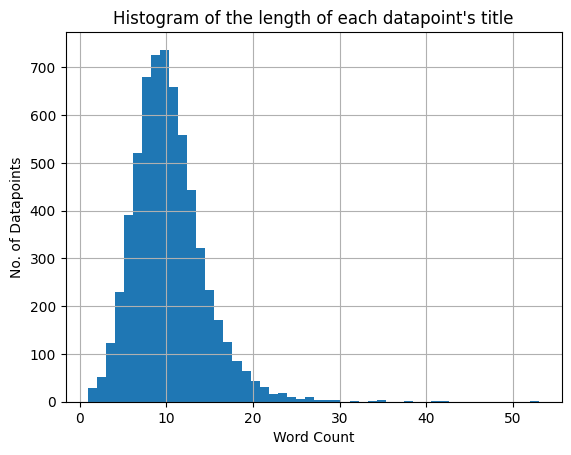

In [10]:
dataset['title_word_count'].hist(bins=50) #histogram of bin number equal to 50 from 'title_word_count' data
pyplot.title('Histogram of the length of each datapoint\'s title') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label
pyplot.show()

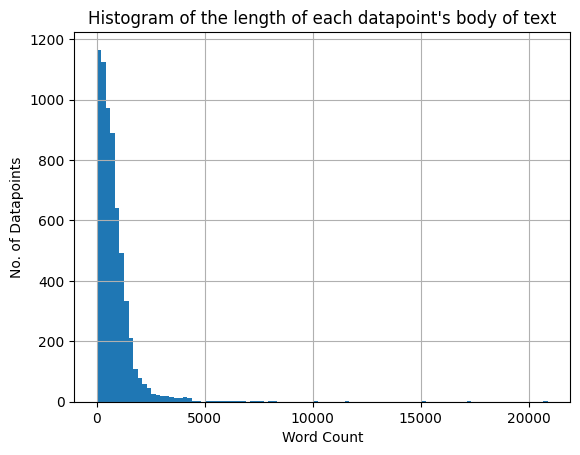

In [13]:
dataset['text_word_count'].hist(bins=100) #histogram of bin number equal to 100 from 'title_word_count' data
pyplot.title('Histogram of the length of each datapoint\'s body of text') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label
pyplot.show()

The mean and variance of the ***title_word_count*** data seem relatively normal. This is reinforced when observing the histogram of this data. The distribution peaks around the mean, roughly, and the spread of data seems reasonable, if we exclude the fact that our variable cannot be negative in value. However,we start to see irregularities when observing the metrics for the ***text_word_count*** data. The mean again seems relatively standard when compared with the histogram. However, the variance is extremely high. Obervation on the respective histogram revelas that there exists numerious data point where the number of words in the main body of text of the new article exceed 10,000 words! This will naturally overwhelm the variance value with our mean being relatively so small compared. All the datapoints that exceed this 10,000 word count margin are shown below.

In [141]:
display(dataset[dataset['text_word_count'] > 10000]) #show all extreme values for 'text_word_count' length

,Unnamed: 0,title,text,label,title_word_count,text_word_count
536,9618,President Putin Asks US To Stop Provoking Russia,Here is President Putin’s speech at Valdai Put...,FAKE,8,11662
1359,5604,Benny Morris’s Untenable Denial of the Ethnic ...,References The Debate \nIt started when Daniel...,FAKE,10,15199
3436,5765,Re: It Is Now Mathematically Impossible To Pay...,It Is Now Mathematically Impossible To Pay Off...,FAKE,13,17332
3685,8441,Re: America Has Become A Lawless Nation – Hill...,America Has Become A Lawless Nation – Hillary ...,FAKE,15,10090
4733,7910,Re: Why Are So Many People Choosing To Leave T...,Why Are So Many People Choosing To Leave The U...,FAKE,13,20891


From this we can make our first discovery about the dataset. Every data point that exceeds the 10,000 word count is classified as **FAKE**. We can use this observation later whose we have developed our first predictive models to see if they have also observed this trend and used this. An observation like this would work incredibly well in a modelling process such as a *decision tree* model. We could now do something smilar with the ***title_word_count*** now to see if any patterns like this can be discovered. Let us ask if data points with ***title_word_count*** values exceeding 30 are typically classified as **FAKE**.

In [142]:
display(dataset[dataset['title_word_count'] >= 30]) #display extreme values for title_word_count

,Unnamed: 0,title,text,label,title_word_count,text_word_count
261,7892,Comment on Breaking: CDC Blocks Testimony of T...,Have you heard of Dr. William Thompson? If y...,FAKE,35,919
436,6329,Muslims regularly use “Inshallah” (“God Willin...,BNI Store Nov 5 2016 Muslims regularly use “In...,FAKE,30,665
1041,5939,Comment on The Science is “Overwhelming At Thi...,This ordinance is a big step forwards by cre...,FAKE,34,2513
1073,7560,Comment on ‘Voting Is Rigged & Used To Pacify ...,Share on Facebook Share on Twitter “This is th...,FAKE,38,1360
1208,5420,12 and 63-minute videos: Donald Trump connects...,"Posted on November 7, 2016 by Carl Herman \nJo...",FAKE,35,1421
1562,7769,Comment on Canadian Air Force Pilot Snaps A Pi...,Share on Facebook Share on Twitter “If it does...,FAKE,32,1077
1580,6031,Comment on Hillary Clinton failed to disclose ...,DCG | 2 Comments \nRules are for little peop...,FAKE,42,730
1663,9064,"Life: If You Love Enamel Pins, You’ll Love Thi...","Email If you can’t get enough enamel pins, the...",FAKE,53,375
2763,8341,Comment on Shocking Insinuation About Carl Sag...,Share on Facebook Share on Twitter A few years...,FAKE,32,3009
3607,6321,Queen Elizabeth II owns every dolphin in Brita...,Email \nQueen Elizabeth II is not like you and...,FAKE,30,2887


As we can see, all 15 data points that have title lengths that exceed or are equal to 30 words are all classified as **FAKE**. This can also be used to determine the success of any models that we evaluate in the future. These finds give us promise that correlations exist within the dataset to allow us to create a reliable prodictive model. Now that we have these findings, we are presented with another question that must be asked; Is there a need for the ***title*** and ***text*** data now? Have we extracted all infomation that may prove usful for our model? No. There still exists relavent information within these string data values. For instance, two of the joint most numerius data values associated with the *title* column are 'OnPolitics | 's politics blog' and 'Michael Moore Owes Me $4.99'. When we display all their respective datapoint out we observe that even though they have the same amount of ***title_word_count*** value, their ***label*** values are mutual exclusive from one another.

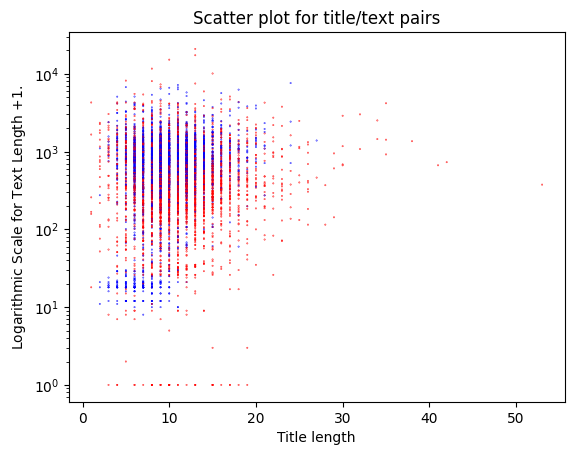

In [52]:
colour = {'REAL': 'blue', 'FAKE': 'red'} #colour mapping dictionary for scatter plot
scatter = pyplot.scatter(dataset['title_word_count'],dataset['text_word_count']+1, c = dataset['label'].map(colour), s=0.4, marker='.') #scatter plot, +1 for log scale
pyplot.xlabel('Title length') #x-axis label of scatter plot
pyplot.ylabel('Logarithmic Scale for Text Length $+ 1$.') #y-axis label for scatter plot
pyplot.yscale('log') #turn y-axis into log scale
pyplot.title('Scatter plot for title/text pairs') #title of scatter plot
pyplot.show()

As we can see from the scatter plot above, some logic is present regarding determining **FAKE** and **REAL** news. Outlier datapoints where ***title_Word_count*** and ***text_word_count*** is either too high or too low are typically labels as **FAKE**. However, a closed form structural review for all datapoints still eludes us. **REAL** and **FAKE** datapoints cluster around eachother, so we can conclude that evaluating just the word count for the tile and the main text of each news article is not enough to reliable predict when the datapoint is within this cluster. So we shall now implement a new metric for our data. We shall implement a sentiment analysis model to out datapoints to get a metric of how possitive or negative an article is. Perhaps a negative article is more likely to be fake than real.

In [243]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #tokenizer converts text into series of numerical values
sentiment_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #load pretrained sentiment model 

def sentiment_score(text): #define function to get sentiment score from model
    """This function calculates the sentiment score using the pretrained model from AutoModelForSequenceClassification library
    
    Parameters
    ----------
    text: str
        Text that will have it's sentiment score evaluated

    Return
    ------
    most_probable_score: int
        The most likely sentiment score for the given text
    """
    tokens = tokenizer.encode(text,return_tensors='pt') #tokenizer encodes given text into numerical values, returned in a pytorch tensor
    output = sentiment_model(tokens) #feed tokenizer data into model
    most_probable_score = int(torch.argmax(output.logits))+1 #convert output array into scores 1,2,3,4 and 5
    return most_probable_score

dataset['title_sentiment_score'] = dataset['title'].apply(lambda x: sentiment_score(x)) #apply function to all title data
dataset['text_sentiment_score'] = dataset['text'].apply(lambda x: sentiment_score(x[:512])) #sentiment model is limited with how many tokens it can process at one time, specifically it is 512, so using only 512st words in text for evaluating

display(dataset.head())

,Unnamed: 0,title,text,label,title_word_count,text_word_count,title_sentiment_score,text_sentiment_score
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,5,1296,5,4
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,14,446,1,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,9,431,4,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,15,404,1,1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,9,317,4,4


In [344]:
title_ss_array = dataset['title_sentiment_score']
text_ss_array = dataset['text_sentiment_score']
title_lengths = dataset['title_word_count']
text_lengths = dataset['text_word_count']

r = np.corrcoef([title_lengths, text_lengths, title_ss_array, text_ss_array]) #Correlation-Coefficient Matrix of all desired variables

print(f'The Correlation-Coefficient Matrix for our 4 evaluated features:\n {r}, \n')

print(f'Correlation-Coefficient between our sentiment scores: {r[3,2]}, \n')

print(f'Correlation-Coefficient between title and text word count: {r[1,0]}.')

The Correlation-Coefficient Matrix for our 4 evaluated features:
 [[ 1.          0.03668925 -0.12064946 -0.07445042]
 [ 0.03668925  1.          0.04231625  0.03485658]
 [-0.12064946  0.04231625  1.          0.2874482 ]
 [-0.07445042  0.03485658  0.2874482   1.        ]], 

Correlation-Coefficient between our sentiment scores: 0.2874481953331301, 

Correlation-Coefficient between title and text word count: 0.036689254710973014.


The above correlation-coefficients yield the desired values. The magnitutde of every correlation coefficient between each feature does not exceed $0.3$, meaning that there does not exist any significant correlation between our intended numerical features for predictive models. This is what we desire. If our features are too correlated with each other, then our models are suseptible to overfitting to data that does not contribute any new insight into our models. What we desire, is for features to correlate with the target label (which we will discover via modelling) and that they arre appropriatly chosen features for our label (since they are all derived directly from the text data which encompasses the text's length and, in a sense, meaning beind the words we can be safe in calling them appropriate for our use).

This sentiment model scores using a scale from 1 to 5, with 1 corresponding with a negative sentiment and 5 being a positive sentiment. However, we have had to make a concession regarding the ***text*** data when evaluating it's sentiment score. Due to limitations with the sentiment model we are using, only the first 512 tokens of text can be used to assess the whole text's sentiment score. This may lead to sentiment scores not reflecting the true score of a body of text, but typically the beginning of an article sets a specific tone for the remainder of the text. This could be in the for or a intorduction which goes over what will be discussed or if its simply stating the purpose of the text. So for our analysis, we will have to assume the following: **The sentiment score for the text for each datapoint remains constant through the text itself**. We will perform this sentiment analysis on both the ***title*** and ***text***. The motivation behind this is that correlation may exist between the ***label*** and the difference in sentiment score between the title of an article and the main body of text, as a form of *click-baiting*. Furthermore, we want to see if our hypothesis is true that negatively sentimented articles are more likely to be ***FAKE***. We could also assess whether extreme sendiment scores on either side of neutral (1 or 5) correlate with labelling articles fake or not, to play to a specific audiance's emotions about a specific issue to get more view.

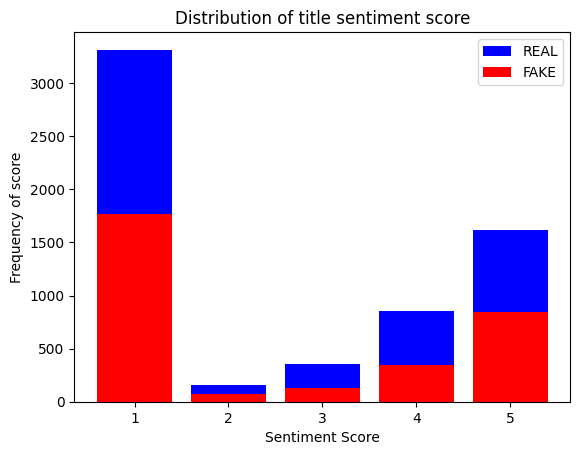

In [281]:
classes = [1,2,3,4,5] 
real_scores = []
fake_scores = []
for score in range(1,6,1):
    real_scores.append(len(dataset[(dataset['title_sentiment_score'] == score) & (dataset['label'] == 'REAL')]))
    fake_scores.append(len(dataset[(dataset['title_sentiment_score'] == score) & (dataset['label'] == 'FAKE')]))

fig, ax = pyplot.subplots()

for item in range(len(real_scores)):
    real_scores[item] = fake_scores[item] + real_scores[item]

ax.bar(classes,real_scores,label='REAL',color='blue')
ax.bar(classes,fake_scores,label='FAKE',color='red')

ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency of score')
ax.set_title('Distribution of title sentiment score')
ax.legend()
pyplot.show()

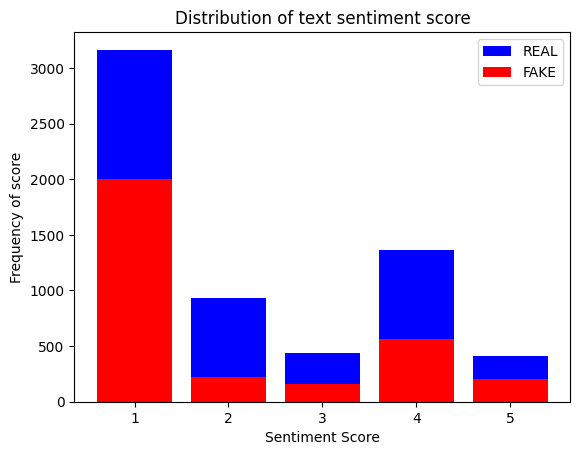

In [282]:
classes = [1,2,3,4,5] 
real_scores = []
fake_scores = []
for score in range(1,6,1):
    real_scores.append(len(dataset[(dataset['text_sentiment_score'] == score) & (dataset['label'] == 'REAL')]))
    fake_scores.append(len(dataset[(dataset['text_sentiment_score'] == score) & (dataset['label'] == 'FAKE')]))

fig, ax = pyplot.subplots()

for item in range(len(real_scores)):
    real_scores[item] = fake_scores[item] + real_scores[item]

ax.bar(classes,real_scores,label='REAL',color='blue')
ax.bar(classes,fake_scores,label='FAKE',color='red')

ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency of score')
ax.set_title('Distribution of text sentiment score')
ax.legend()
pyplot.show()

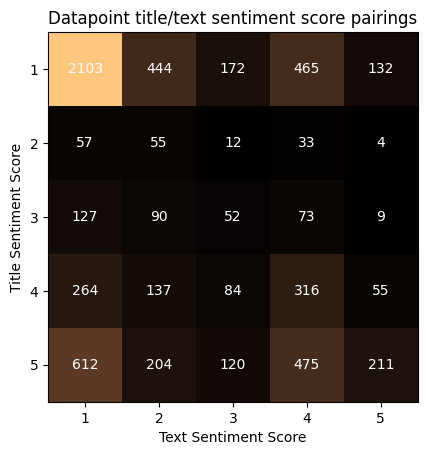

In [306]:
title_score_classes = ['1','2','3','4','5']
text_score_classes = ['1','2','3','4','5']

f = lambda i, j: len(dataset[(dataset['title_sentiment_score'] == i+1) & (dataset['text_sentiment_score'] == j+1)])
score_matrix = np.fromfunction(np.vectorize(f), (5,5), dtype=int)

fig, ax = pyplot.subplots()
im = ax.imshow(score_matrix,cmap = 'copper')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(title_score_classes)), labels=title_score_classes)
ax.set_yticks(np.arange(len(text_score_classes)), labels=text_score_classes)

# Loop over data dimensions and create text annotations.
for i in range(len(title_score_classes)):
    for j in range(len(text_score_classes)):
        text = ax.text(j, i, score_matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Datapoint title/text sentiment score pairings")
pyplot.xlabel('Text Sentiment Score')
pyplot.ylabel('Title Sentiment Score')
pyplot.show()

Note that a significant proportion of sentimental scores for both title and text are valued at 1. This can be explained as news outlets reference to use negative language to attract the attention of viewers so as to gain an increase in footfall on their respective websites. However, we must be ever aware of the assumption we have made regarding the sentiment score of the text of the article. We may also be experiencing an inflation in negatively sentimented scores due to articles possibly being written more negatively than what the whole article actually reflects to keep viewers reading. But, the proportion of **REAL** and **FAKE** new articles across all scores for both title and text data is promising for us and our models when training. We do not want to accidentaly train our models on data that is entirely fake for a certain sentiment score, this would lead to our models creating an untrue correlation and would yield unfavourable predictions. 

In [36]:
def save_csv_data(dataset):
    '''This function saves the given dataset as a .csv file named 'cleaned_news.csv'
    
    Parameters
    ----------
    dataset: pandas.core.frame.DataFrame
        Pandas dataframe to be saved in a .csv file in the current working directory
    '''

    dataset.to_csv('cleaned_news.csv',index=False)
    return

save_csv_data(dataset)

### Normalising Feature Data

If we obersve the histograms of the distribution of title word count across all data points, it seems to be distributed in a normalised manner. Meaning that conversion to their respective $Z$-scores is not completely necessary. If model performance is not up to our expectations, these values will be converted to normal values using the $Z$-score transform:

$$
z_i = \frac{x_i - \mu}{\sigma}.
$$

However, we can clearly see that the text word count follows a power law distribution. It is good practice to convert values drawn from such distributions to become more normalised so that weights associated with this feature in the future act accordingly. To convert these values, we can simply take the logarithm of the word count numbers:

$$
x_i \longrightarrow{} \log{(x_i)}.
$$

Doing so should resulting in a distribtuion that resembles a normal distribution. Indeed, once transformed we get the following histrogram distribution. Although not the msot convincing normal distribution, it should be good enough for our weighting during modelling to behave the way we desire. If unusual results ensue, normalisation and extreme values may be removed and considered outliers.

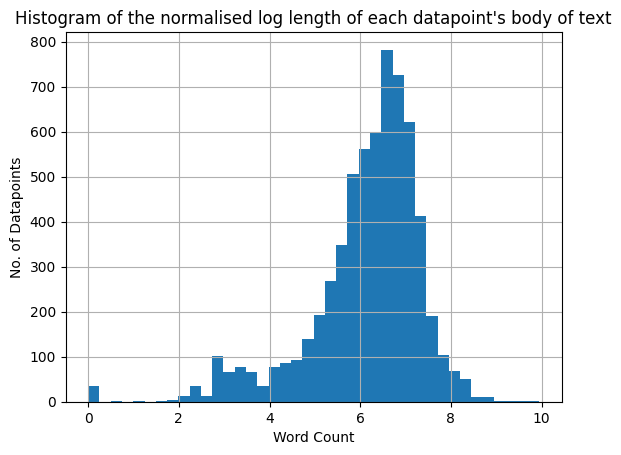

In [75]:
dataset = pd.read_csv('cleaned_news.csv')

log_text_word_count = (dataset['text_word_count']+1).apply(np.log)

log_text_word_count.hist(bins=40)
pyplot.title('Histogram of the normalised log length of each datapoint\'s body of text') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label
pyplot.show()

Now that we have our normalised data, we shall create respective columns to store them in the dataset.

In [37]:
dataset['log_text_word_count'] = log_text_word_count
save_csv_data(dataset)

### Topic Modelling

Topic modelling would have provided us with other features that could have been used to determine the label of a data point. Topic model takes in a body of text and returns the most likely topic the body of text is discussing. This could provide additional infomation encoded within the original text data provided. For instance, maybe new articles that are classified as '*political*' are majority FAKE, but article classed as *entertainment* are mostly REAL. This additional infomation could be used to distinguish between very similar data points so as to stop our model labelling both as FAKE or REAL when inreality they are not the same.

## Modelling

### Baseline models

The gauge the success of our models, we will present a baseline model to compare future classification models with. The standard baseline model that we could us takes the form of a uniform random coin-toss. Since our models will be determining the ***label*** of a data point, which can only take the classes **REAL** or **FAKE**. Thus, a model that chooses between these two classes with equal probability can be expected to get an accuracy score of $50$%. So for future models that we derive, if they are an improvement upon an accuracy score of $50$%, we could begin to consider the effectiveness of this model.

### Custom Model (Dimensional Expansion)

Motivated by the scatter plot that compared the distibution of log text length and title length pairings, a possible simple approach to determining the correct label for a given pairing is by extending this plot into a higher dimension which separates the two clusters of true labeled data points. Suppose that our title/text pairings are of the form $(x,y)$. Then, we seek to find a mapping $f(x,y)$ such that,

$$
\left(x,y\right) \longrightarrow{} \left(x,y,f(x,y)\right).
$$

This mapping function could take any deterministic form. However, for this example we can suppose a relatively simple function for separating differntly labeled data points $(x,y)$. The function we will use is of the form,

$$
f(x,y) = \sum_{i=1}^{N_{\text{cluster}}} \frac{1}{\alpha_{i}(\hat{x}_i-x)^2+\beta_{i}(\hat{y}_i-y)^2},
$$

where $N_{\text{cluster}}$ is the number of clusters we want to sperate from the rest of the data, $(\hat{x}_i,\hat{y}_i)$ is the center of each cluster and the constants $\alpha_{i}, \beta_{i}$ are amplifiers to allow us to extend our surface in an elliptical manner. This is important since our clusterings in our original scatter plot are not perfect circles, they appear to be elliptical, thus these constants allow us flexibility into what we extend abow for separation. To determine how we classify labels after this dimensional expension, we introduce a plane, $c(x,y)$. This curve can also take an arbitrarily complex form we desire. However, for a simple model we can take this to be a flat plane or even a constant function. For a flat plane function, $c(x,y)$ takes the form, 

$$
c(x,y) = ax+by+c, \text{ where  }a,b,c \in \mathbb{R}.
$$

Once we have established these functions, we can construct the methods for determining labels for our model. Indeed, since we are trying to extend the dimensionality such that we seperate 'REAL' and 'FAKE' news articles where 'REAL' data points are located above our iontersection curve $c(x,y)$, then our classification model takes the form,

$$
f(x,y) > c(x,y) \implies \text{label}(x,y) = \text{'REAL'},
$$

otherwise $\text{label}(x,y) = \text{'FAKE'}$. To help visualise the dimensional extension for our system of points, observe the plot below that shows how we can *pull* the surface lift it above the resting area. Then we can say that if a data point is above the resting surface by a certain amount, we classifiy it as real or fake.

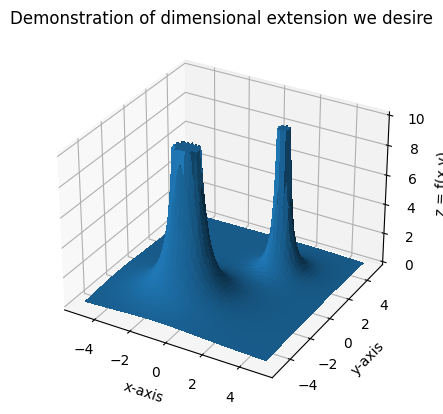

In [20]:
ax = pyplot.figure().add_subplot(projection='3d')

X = np.linspace(-5, 5, 5000)
Y = np.linspace(-5, 5, 5000)
X_mesh, Y_mesh = np.meshgrid(X, Y)
Z = 1/(0.2*(-1-X_mesh)**2+0.3*(-2-Y_mesh)**2) + 1/((2-X_mesh)**2+(2-Y_mesh)**2)
for i in range(len(X)):
    for j in range(len(Y)):
        if Z[i,j] > 10:
            Z[i,j] = 10

ax.plot_surface(X_mesh, Y_mesh, Z, linewidth=0, antialiased=False)
ax.set_zlim(0,10)
pyplot.title('Demonstration of dimensional extension we desire')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z = f(x,y)')
pyplot.show()

From the plot above, we can see that points that exist close to the points (-1,-2) and (2,2) are elavated above the x-y plane. So if we chose a center point in the middle of a cluster of a certain class, then this cluster will be elaveted as well. Thus, we can now judge whether a data point is of a certain class by the whether is has evalated above the x-y plane. However, we cannot just "*if z > 0, then our data point is of a certain class*", as mathematically every point is above this plane. So to perform this logic, our model would class every point as a single class. Therefore, we must give it a threshold that a data point's z-value. For our simple model, we can use a basic threshold to evalute this criteria. We shall use the following logic for our model: "*If a data point's z-value is greater than or equal to 1, then it is classed as REAL. Else it is FAKE*".

In [4]:
dataset = pd.read_csv('cleaned_news.csv')

X = dataset[['title_word_count','log_text_word_count','title_sentiment_score','text_sentiment_score']]
y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) #to create a 60-20-20 split in data sets

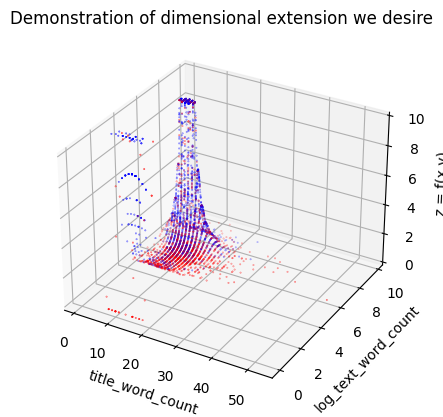

In [70]:
ax2 = pyplot.figure().add_subplot(projection='3d')

X = X_train['title_word_count']
Y = X_train['log_text_word_count']
Z =  1/(0.02*(9-X)**2+2*(7-Y)**2) + 1/(0.001*(6-X)**2+0.9*(2.5-Y)**2)
for item in range(len(Z)):
    if Z[item] > 10:
        Z[item] = 10 

colour = {'REAL': 'blue', 'FAKE': 'red'}
ax2.scatter(X, Y, Z, c = y_train.map(colour).to_list(), s=0.4, marker='.')
ax2.set_zlim(0,10) 
pyplot.title('Demonstration of dimensional extension we desire')
ax2.set_xlabel('title_word_count')
ax2.set_ylabel('log_text_word_count')
ax2.set_zlabel('z = f(x,y)')
pyplot.show()

The above scatter plot uses the training data for modeling to display how data points a distributed across space given a dimenional expansion function $f$. IF we observe this scatter plot, we notice that most of the data points classifier as 'REAL' (blue) have been transformed above the x-y plane that the original scatter point inhabits. For our simple model we can take the curve that we will judge the label of a dat point to be constant. Optimisation for choosing the best constant value to use could be implemented, however this approach is intended to be base model so getting the best model is not required. We shall use $c(x,y) = 1$ to evaluate the label of a data point. Thus, roughly estimating the constant values for the function, we get that for a data point to be classified as 'REAL', the following inequality must be satisfied;

$$
\frac{1}{0.02(9-x)^2+2(9-y)^2} + \frac{1}{0.001(6-x)^2+0.9(2.5-y)^2} \geq 1,
$$

where $x$ represents the title word count and $y$ the text word count. Now that we have the method for modelling labels, we can implement it for our validation set to evaluate the accuracy of our model. Indeed;

In [68]:
def custom_model(X_valid, y_valid):
    '''This function performs our classification model for news articles
    
    Parameters
    ----------
    X_valid: pandas.core.frame.DataFrame
        Pandas dataframe that contains the features to be used for our model
    
    y_valid: pandas.core.frame.DataFrame
        Pandas dataframe that contains the labels of the respective data in X_valid 
        
    '''
    x = X_valid['title_word_count']
    y = X_valid['log_text_word_count']
    label_df = 1/(0.02*(9-x)**2+2*(7-y)**2) + 1/(0.001*(6-x)**2+0.9*(2.5-y)**2)
    label_df['label'] = label_df.apply(lambda x: 'FAKE' if x < 1 else 'REAL')

    prediction = label_df['label']

    df_compare = pd.concat([prediction,y_valid],axis=1)
    df_compare.columns = ['prediction','actual']

    df_tp = df_compare[(df_compare['prediction'] == 'FAKE') & (df_compare['actual'] == 'FAKE')] #
    df_fp = df_compare[(df_compare['prediction'] == 'FAKE') & (df_compare['actual'] == 'REAL')] #
    df_tn = df_compare[(df_compare['prediction'] == 'REAL') & (df_compare['actual'] == 'REAL')] #
    df_fn = df_compare[(df_compare['prediction'] == 'REAL') & (df_compare['actual'] == 'FAKE')] #

    tp, fp, tn, fn = len(df_tp), len(df_fp), len(df_tn), len(df_fn)

    accuracy = (tp+tn)/(tp+fp+tn+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision + recall)

    cm = pd.crosstab(df_compare['prediction'],df_compare['actual'])

    print(f'Accuracy of our custom model: {accuracy},\nPrecision Score of our custom model: {precision},\nRecall Score of our custom model: {recall},\nF1 Score for our custom model: {f1_score},\nConfusion Matrix for our custom model:\n\n {cm}')
    return

custom_model(X_valid,y_valid)

Accuracy of our custom model: 0.6661379857256146,
Precision Score of our custom model: 0.6573208722741433,
Recall Score of our custom model: 0.6773675762439807,
F1 Score for our custom model: 0.6671936758893281,
Confusion Matrix for our custom model:

 actual      FAKE  REAL
prediction            
FAKE         422   220
REAL         201   418


We get that our model has an accuracy rating from the validation set of $66.6$%. This is surpisingly high considering the models that are about to follow. This is especially significate considering the only features used to assess whether a news article is fake or real is the length of the word count of the title and the text. However, this appraoch has its flaws. Firstly, there is nothing stopping a fake news article from having the same number of words as a real website. So if this was assess after all websites, we would undoubtedly encounter enough websites that share the properties that our models relies on to invalidate our model. Furthermore, our initial assumption that real news articles coalesce around certain points is based upon the scatter plot of ALL the data, which includes the validation and test sets. This could be construded as cheatig since we already know how the validation and test sets will behave. These sets are meant to be completely unknown to our model, yet they are used in the fundamental principles of it. To recify this, we should of only observed the training data in the construction of this model.

### Logistic Regression

Now that we have our data prepared, we shall begin by splitting our data into the training, validation and test sets, each with the appropriate features and labels. After the partition of for our modeling, we shall implement the Logistic Regression along with a Grid Search to fins the optimal hyperparameters from a given parameter directory. The best parameters for our model and the corresponding model metrics are presented below. 

In [5]:
def run_model(model_class, hyper_dict):
    '''This function performs a gridsearch for the best model from the given hyperparameter dictionary, evaluates the key performance metrics and saves all key infomation in corresponding files

    Parameters
    ----------
    model_class: type
        Model class to be used for the modelling process

    hyper_dict: dict
        Dictionary of lists of possible parameter values to perform gridsearch
    
    '''
    model = model_class() #logistic model
    gridsearch = GridSearchCV(model,hyper_dict) #perform gridsearch for the all model settings
    fit_model = gridsearch.fit(X_train,y_train) #fit using training sat
    best_estimator = fit_model.best_estimator_ #best estimator from all permutations of settings

    prediction = best_estimator.predict(X_valid) #predict using validation set

    precision_value = precision_score(y_valid,prediction,average='weighted',zero_division=0) #precision score
    recall_value = recall_score(y_valid,prediction,average='weighted',zero_division=0) #recall score
    f1_value = f1_score(y_valid,prediction,average='weighted') #f1 score
    accuracy_score = best_estimator.score(X_valid,y_valid) #accuracy score
    cf = confusion_matrix(y_valid,prediction) #confusion matrix
    cf_plot = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = best_estimator.classes_) #class to display confusion matrix

    metric_dict = {
        'Accuracy': accuracy_score,
        'Precision Score': precision_value,
        'Recall Score': recall_value,
        'F1 Score': f1_value
    }

    print('MODEL METRICS')
    print('-------------\n')
    print(f'Model Parameters: {best_estimator.get_params()}.\n')
    print(f'Accuracy Score: {accuracy_score},\nPrecision Score: {precision_value},\nRecall Score: {recall_value},\nF1 Score: {f1_value}.')
    print('Confusion Matrix:')
    display(cf_plot.plot())

    dir_name = type(model_class()).__name__ #return name of model from class    
    try:
        os.mkdir(f'{dir_name}/')
    except:
        pass
    joblib.dump(best_estimator,f"{dir_name}/model")

    with open(f"{dir_name}/parameters.json", "w") as f:
        json.dump(best_estimator.get_params(), f)

    with open(f"{dir_name}/metrics.json", "w") as f:
        json.dump(metric_dict, f)
    
    if 'confusion_matrix.png' in os.listdir(f'{dir_name}'):
        os.remove(f'{dir_name}/confusion_matrix.png')
        cf_plot.figure_.savefig(f'{dir_name}/confusion_matrix.png')
    return

MODEL METRICS
-------------

Model Parameters: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}.

Accuracy Score: 0.6360031720856463,
Precision Score: 0.6360098465962388,
Recall Score: 0.6360031720856463,
F1 Score: 0.6358299739034027.
Confusion Matrix:


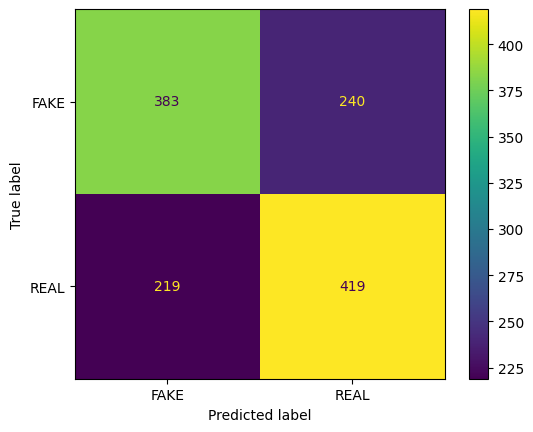

In [64]:
#Logistic Regression Classifier
hyper_dict = {
    'C': [1,0.5,0.1],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky','saga','sag'],# excluding 'newton-cg' solver as its unable to converge to best fit line
    'multi_class': ['auto','ovr'], #excluding multinomial due to incompatability with 'liblinear' solver
    'max_iter': [1000000] #to remove warning messages
}

run_model(LogisticRegression,hyper_dict)

Compared to our theoretical baseline model, we see an increase in the accuracy for correct predictions by about $13.6$%, with the overall accuracy of our logistic regression model at $63.6$%. We can also notice that the recall and precision scores for our model are very similar, showing that our model holds no favouratism towards false-positive or false-negative. This is reflected in confusion matrix displayed above. The values for correct and incorrect predictions for each class is very similar. This also reassures us that the number of real and fake news articles used to fit and assess the model are roughly split 50-50. This exposer to equal amounts of each class causes our model to create healthy connections with the data which gives our model a better chance of avoiding predictions incorrectly due to a lack of training data of that class.

### Decision Tree

A Decision Tree model is as it sounds. The structure of the model is a tree network that branches out. The way that this structure is determined is through the model parameters. Each branching point on the network corresponds with a criteria check for the input data. Once the data has passed throuch the tree, it reaches a leaf node which will (in a classification problem) assign it a class that was determined through the training data. 

MODEL METRICS
-------------

Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 1, 'min_weight_fraction_leaf': 0.0, 'random_state': 21, 'splitter': 'random'}.

Accuracy Score: 0.6280729579698652,
Precision Score: 0.6280662619671246,
Recall Score: 0.6280729579698652,
F1 Score: 0.6280692149900069.
Confusion Matrix:


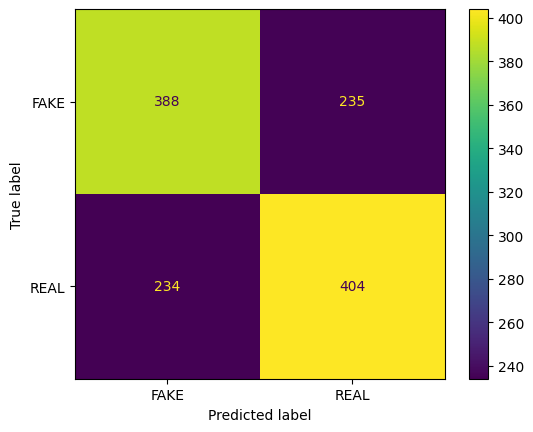

In [68]:
#Decision Tree Classifier
hyper_dict = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best','random'],
    'min_samples_split': [1, 2, 3],
    'random_state': [1, 21, 42]
}

run_model(DecisionTreeClassifier,hyper_dict) #random_state given to allow for reproducability of result.

From this metrics, we can state that the logistic model has performed better than this newly derived decision tree model. For instance, the accuracy of our logistic model was $63.6$%, whereas our Decision Tree model holds an accuracy of $62.8$%. Furthermore, all other metrics to evaluate the succes of our model yields better values. This improvement can clearly be seen within the confusion matrices of both models. In all diagonal entries, we see an increase in these number (remember that these represent the correct predictions). However, we seen that our decision tree model, although overall a worse performing model, decreases the likely hood of achieving a false positive (top-right segment of our confusion matrix). So if we are wanting to model a process that must have a lower tolerance for false positives, we may consider choosing our lesser model for this. Furthermore, producing predictionsis must quicker that other models as very few calculations have to be made relative to other models during the prediction process.

### Random Forest

Much like Decision Tree models, Random Forests use multiple, randomly configured, decision trees. The data is then passed through all of these trees to get a collecting of possible classes this data could take. These outputs are then used to determine the final class of the data via a majority vote.

MODEL METRICS
-------------

Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}.

Accuracy Score: 0.662172878667724,
Precision Score: 0.6629514844358855,
Recall Score: 0.662172878667724,
F1 Score: 0.6614305943982834.
Confusion Matrix:


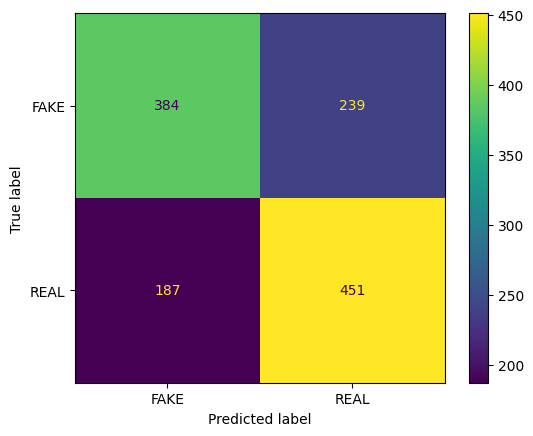

In [69]:
#Random Forest Classifier
hyper_dict = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini','entropy','log_loss'],
    'min_samples_split': [1, 2, 3],
    'random_state': [1, 21, 42]
}

run_model(RandomForestClassifier,hyper_dict)

With this Random Forest model, we get an imporvement from the previous model with an accuracy rating of $66.2$%. We again see imporvements across all metrics regarding the previous model. However we see another intriguing property of our model in the confusion matrix. Notice that our model has improved numbers when trying to predict ***REAL*** classes data, with an increase in correct prediction and a decrease in incorrect predictions. But we see a decrease the effectiveness when trying to predict ***FAKE*** news articles, with a decrease in correct predictions and an increase in incorrect predictions. This tells use that our model holds a slight bias towards classifying new articles as ***REAL***. This may seem concerning but the relative decreases in effectiveness are mitigated by the magnitude of the increase in effectiveness in the other aspects of the model.

### Gradient Boosting

MODEL METRICS
-------------

Model Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}.

Accuracy Score: 0.71847739888977,
Precision Score: 0.7185214418748926,
Recall Score: 0.71847739888977,
F1 Score: 0.7183976836264432.
Confusion Matrix:


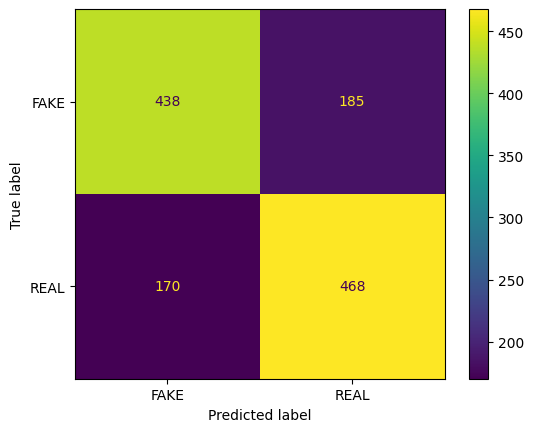

In [70]:
#Gradient Boosting Classifier
hyper_dict = {
    'loss': ['log_loss','exponential'],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [50, 100, 200],
    'random_state': [1, 21, 42]
}

run_model(GradientBoostingClassifier,hyper_dict)

### AdaBoost

MODEL METRICS
-------------

Model Parameters: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': 1}.

Accuracy Score: 0.6938937351308485,
Precision Score: 0.693926240822371,
Recall Score: 0.6938937351308485,
F1 Score: 0.6937981949037002.
Confusion Matrix:


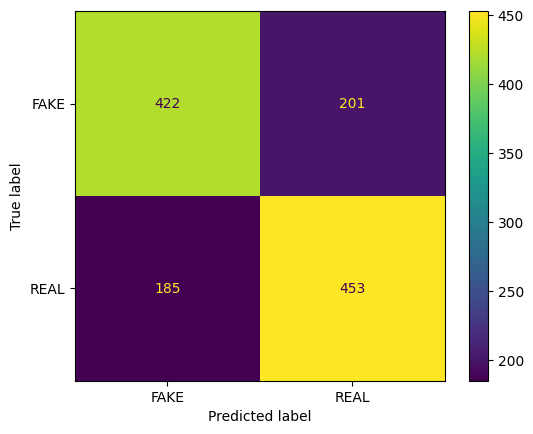

In [71]:
#Ada Boost Classifier
hyper_dict={
    'n_estimators': [50, 100, 150, 200],
    'algorithm': ['SAMME','SAMME.R'],
    'random_state': [1, 21, 42]
}

run_model(AdaBoostClassifier,hyper_dict)

### KNeighborsClassifier

This modelling method used basic logic about the *distance* between modelled data points and training data points to decide which class to assign to the given input data point. The *KNeighborsClassifier* from the *sklearn* package uses as default the $L_2$ distance metric (Minkowski Measure). The formula for the generalised $k^{\text{th}}$ measure is defined below; 

$$
L_k(p,q) := \left( \sum_{i=1}^{N} | p_i - q_i |^k \right)^{\frac{1}{k}}.
$$

MODEL METRICS
-------------

Model Parameters: {'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 3, 'weights': 'uniform'}.

Accuracy Score: 0.6812053925455988,
Precision Score: 0.6821334604776176,
Recall Score: 0.6812053925455988,
F1 Score: 0.6805049271082393.
Confusion Matrix:


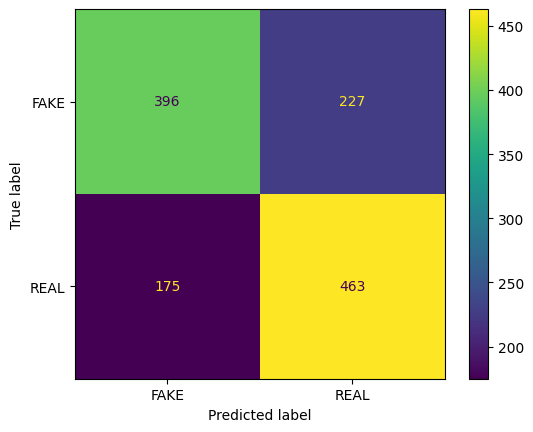

In [7]:
#K Neighbors Classifier
hyper_dict = {
    'n_neighbors': [5,7,9,11], #For Binary classification, choose k to be odd to eliminate possibility of ties
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [2,3,4,5]
}

run_model(KNeighborsClassifier,hyper_dict) #Default Minkowski metic for distance function

### MLPClassifier (Neural Network)

MODEL METRICS
-------------

Model Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (10, 10, 10, 4), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}.

Accuracy Score: 0.711340206185567,
Precision Score: 0.7117714784967073,
Recall Score: 0.711340206185567,
F1 Score: 0.7110373144814286.
Confusion Matrix:


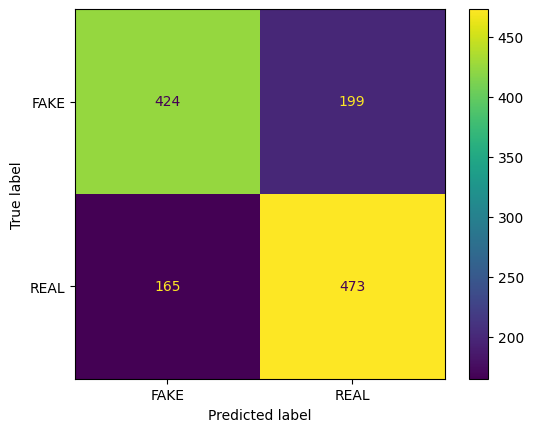

In [6]:
#MLP Neural Network Classifier
hyper_dict = {
    'hidden_layer_sizes': [(8,10,8,4),(10,10,10,4),(10,12,10,4)],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant','invscaling','adaptive'],
    'max_iter': [100000],
    'random_state': [1, 21, 42]
}

run_model(MLPClassifier,hyper_dict)

## Best Model

Assessing the bect model has to be taken on a base-by-base situation. If we require our model to prioritise the minimisation of false-positives, say for a facial recognition model that protects very sensitive infomation, we would chose our model with the highest precision score. However, if we required a model that minimises the number of false-negatives, say a model that assess whether a produce on a conveyer system has passed a visual inspection for defects, then we would prioritise a higher recall score. For our project, we will simply assess the best model by how often it predicts correctly, the accuracy score. The accuracy scores for every model we trained during this project can be found in the table below.

|Metric|Flip-A-Coin|Custom|LogisticRegression|DecisionTree|RandomForest|GradientBoosting|AdaBoost|KNeighbors|MLP|
|----------|-|-|----------------|------------|------------|----------------|--------|----------|---|
|Accuracy  |0.500|0.666|0.636|0.628|0.662|**0.718**|0.694|0.681|0.711|

Since our *GradientBoosting* model produced the highest accuracy score for the validation data, we shall conclude that this is the best model for predicting real and fake new articles. We shall now perform predictions using this model on the unseen test dataset to make our final predictions.

TEST DATA STATISTICS
--------------------
Test Accuracy: 0.7321711568938193,
Test Precision Score: 0.7327580521513195,
Test Recall Score: 0.7321711568938193,
F1 Score: 0.732153667436342.
Confusion Matrix:


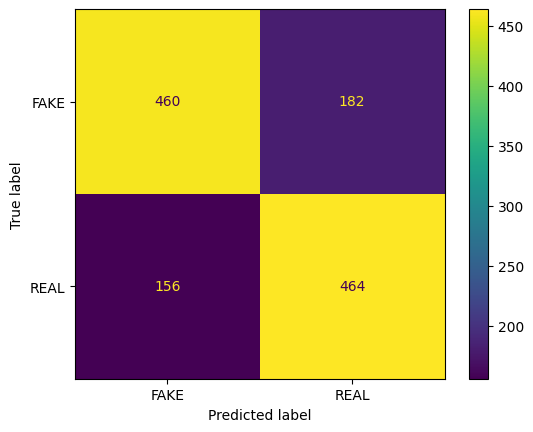

None

BEST MODEL PARAMETERS
---------------------
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: exponential
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 3
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_iter_no_change: None
random_state: 1
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False


In [9]:
load_model = joblib.load('GradientBoostingClassifier/model')
prediction = load_model.predict(X_test)

accuracy = load_model.score(X_test,y_test)
precision = precision_score(y_test,prediction,average='weighted')
recall = recall_score(y_test,prediction,average='weighted')
f1 = f1_score(y_test,prediction,average='weighted')
cf = confusion_matrix(y_test,prediction) #confusion matrix
cf_plot = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = load_model.classes_) #class to display confusion matrix
cf_plot.plot()

print('TEST DATA STATISTICS')
print('--------------------')
print(f'Test Accuracy: {accuracy},\nTest Precision Score: {precision},\nTest Recall Score: {recall},\nF1 Score: {f1}.\nConfusion Matrix:')
display(pyplot.show())
print('BEST MODEL PARAMETERS')
print('---------------------')
for param in load_model.get_params():
    print(f'\033[1m{param}\033[0m: '+ str(load_model.get_params()[f'{param}']))

The metrics evaluated fro the test set are promising. Our models performance mertics remain at a high level with an accuracy rate for our test set of $73.2$%. This consistantly high percentage shows us that our models has discovered a pattern using the features given (thus avoiding underfitting) and has been able to consistantly keep it performance metrics when used on unseen data (suggesting no significant overfitting has occurred). Thus our models bias-variance trade-off has yielded a balance process. In regards to capturing any patterns hidden within the feature data, we can now use the predictions made to create a visualisation of how well the model did at predicting the given test set. First, we shall see a scatter plot, like the one found at the start of this report, which plots the title lenght against the log text length with each datapoint coloured corresponding to their true labels. This plot will give us the true structure of the data and see how well our model did at discovering these structures within the data.

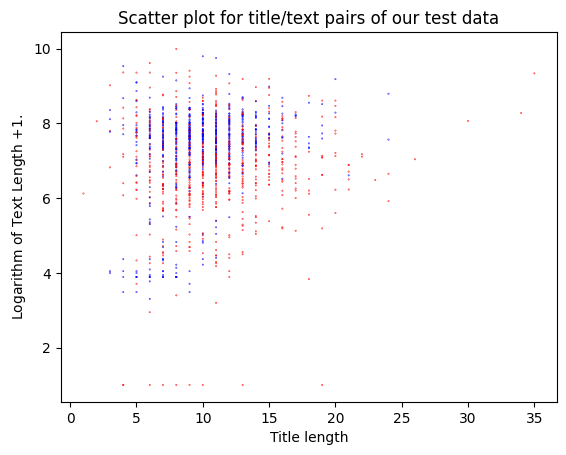

In [19]:
colour = {'REAL': 'blue', 'FAKE': 'red'}
scatter = pyplot.scatter(X_test['normal_title_word_count'],X_test['normal_log_text_word_count']+1, c = y_test.map(colour), s=0.4, marker='.')
pyplot.xlabel('Title length')
pyplot.ylabel('Logarithm of Text Length $+ 1$.')
pyplot.title('Scatter plot for title/text pairs of our test data')
pyplot.show()

This plot shares striking resemblence to our original scatter plot for the whole dataset. We can see the main large grouping of real (BLUE) articles in the main cluster. WE can also see the off-branch below that contains mostly of real data points. Further, we see that the extreme datapoints to the right and below the main clustering are all fake (RED) articles. Using this as a informal measure of the success of our model, we can see where our modelling method discovered the correct structure and where there is room for improvement.

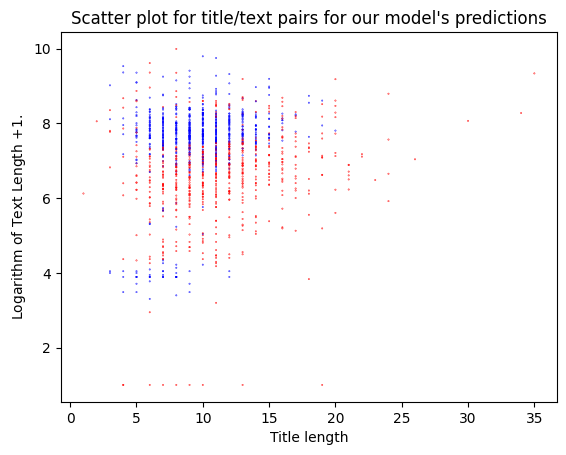

In [21]:
colour = {'REAL': 'blue', 'FAKE': 'red'}
scatter = pyplot.scatter(X_test['normal_title_word_count'],X_test['normal_log_text_word_count']+1, c = np.vectorize(colour.get)(prediction), s=0.4, marker='.')
pyplot.xlabel('Title length')
pyplot.ylabel('Logarithm of Text Length $+ 1$.')
pyplot.title('Scatter plot for title/text pairs for our model\'s predictions')
pyplot.show()

We can see a striking similarity between the two scatter plots above. Our model clear discovered the two prominent clusters of REAL new articles and ajusted is prediction accordingly. We also see that it is able to recognise the extreme values correctly as FAKE. It's naturaly not a perfect mimicry. For instance, there is significantly less mingling of data point classes along the boundary of the clusters. It's not able to determine the subtleties when a cluster is not present, typically classing it as FAKE. However this is not unexpected. If data points are very similar in regards to their title length and log text length, then the only other features that can be used to distinguish them is the sentiment scores for each feature. These sentiment scores are also not the most reliable features to use since, for instance, the text data was only evaluated for the first 512 words due to the limitations of the sentiment model used for this project. Perhaps a better pretrained model that would of allowed us to evaluate the whole text and not just a fraction of it would have yielded more reliable results. Especially when evaluating the sentiment scores for extremely large texts.

## Potential Imporvement in the future

Even though a model was derived that produces respectable performance metrics considering the starting dataset used, there are potential improvements that may have resulted in a best model.

1. *Author of News Article*: If we were aware of how published the news article, I'm confident we would witness improvements in the perfromance of our models overall. This wold be a relatively safe assumption to make as an individual publisher would either be working for a large news company/department that (you'd hope) peform backgroung checks to confirm any news article they published, or a relatively small company/department (or even an independent author) that would be unable to fact-check news articles they publish. These links would help improve our modelling process significantly.

2. *News Publisher*: Same logic for the author of the article, if we were privy to the knowledge of which organisation/website initially published the article, our model would be able to distinguish between reputable news outlets and those that must be taken with a grain of salt.

3. *Date of Publication*: [Pennycook, Cannon, and Rand](https://uvic.summon.serialssolutions.com/#!/search?bookMark=eNp9kU1P3DAQhi20CBbKpT8AReoFIWXrr9jJpRJCUJBWlEM5WxNnTLNk49TeAPvv8WrL9uPQufrxo3nnPSKT3vdIyEdGZ4wK_fn1EWkaqYo9MmWVqHKeZkKmlFYqF1IWh-QoxsUGEqU6IIeCcqlpoaekvA-tD9nV6-DjGDC77W1AiBizewwW22dssgtrxwB2nXmXXcMTZnf4Ej-QfQddxBMyWYURj8nD9dX3y5t8_u3r7eXFPAdJtc4LXVEUUoPVVjjheF05VzeNRQ1pdaglkzVKxXjVqLoGpx1HkE4xcJQ3pTgmX7beYayXmP71qwCdGUK7hLA2Hlrz90vf_jCP_tkorqt0kSQ4-yUI_ueIcWWWbbTYddCjH6PhjDEtGS95Qj_9gy78GPqUMlGK0aLghfo_tZGpoqSJOt9SNvgYA7rdyoyaTWvmd2sJPv0z5A59rykBsy0AA5ghri2EVWs7jKmYkIJvZIZJbRg3rEzGN7CZo3A) (2018) showed that individuals are more likely to deem a false statement true the more times they are exposed to it. And as fake news spreads, the more news articles published at around the same time. This massive influx of fale news articels is how fake news proporgates acorss the general population. Thus, if we were knowing of the publication time/date of the news articles, our models would be able to find these spikes in publication nubers at certain dates and use this to contribute towards their prodictive power.

4. *Improvements in computing power*: This problem most likely will blight the vast majority of data science project, recreational or professional, however it is important to state none-the-less. With finite time (and not the best laptop to perfrom this script on) there are limitations that must be abidded when dealling with this problem. For instance, when performing the *run_model* function on the MLPClassifier with it respective hyperparamter dictionary, it took 37 minutes to run this to completion. This was admittedly with 81 different model configuration for the GridSearch, but this was with only choosingn 3 options for 4 parameters of the model. The chances that we chose the best parameters for this model from a relatively small sample of paramter selectiong is virtually zero. We can only make do with hoping that the GridSearch produced a model relatively close to the best model. Furthermore, when calculating the sentiment scores for the title and body of text in our dataset, the whole process took roughly 75 minutes! Agian this is with over 12000 values to calculate. This does result in a sentiment score beeing evaluated on average every 0.375 seconds. But if we are to use this to evaluate whether a news article is real or fake in real-time (instead of on a dead dataset) with potentially 1000s of new data points being streammed every second, this approach simply cannot keep up, or the commputational power has to be improved. Therefore, we are restricted in what we are able to do. This problem is slightly trivial consdiering this project is solely rectreational but has to be noted.